In [10]:
import os
import json
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 


from utils.vis import plot_images_nib, plot_images_sitk, analyze_inhale_exhale
from utils.preprocessing import hu_data, remove_gantry
from utils.segment import apply_lungmask_binary

In [2]:
DATA_PATH = './data'
RESULT_PATH = './results'
PARAMETER_PATH = './parameter'
ELASTIX_PATH = '/Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/elastix'
dataset_info = json.load(open("./data/dataset_info.json"))
save = False
vis = False

# Image Check

In [3]:
key = 'copd4'
inhale_image = nib.load(os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz'))
exhale_image = nib.load(os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz'))
inhale_data = inhale_image.get_fdata()
exhale_data = exhale_image.get_fdata()

In [4]:
if vis == True:
    plot_images_nib([inhale_image, exhale_image], titles=[f"{key} Inhale", f"{key} Exhale"], cols=2, slice_idx=50, fig_size=(10, 10))

In [5]:
if vis == True:
    analyze_inhale_exhale(inhale_data, exhale_data)

In [6]:
hu_inhale = hu_data(inhale_data)
hu_exhale = hu_data(exhale_data)

In [7]:
if vis == True:
    analyze_inhale_exhale(hu_inhale, hu_exhale)

In [8]:
if save == True:
    inhale_save = os.path.join(DATA_PATH, key, f'{key}_iBHCT_hu.nii.gz')
    exhale_save = os.path.join(DATA_PATH, key, f'{key}_eBHCT_hu.nii.gz')

    inhale_image_hu = nib.Nifti1Image(hu_inhale, inhale_image.affine)
    exhale_image_hu = nib.Nifti1Image(hu_exhale, exhale_image.affine)
    nib.save(inhale_image_hu, inhale_save)
    nib.save(exhale_image_hu, exhale_save)

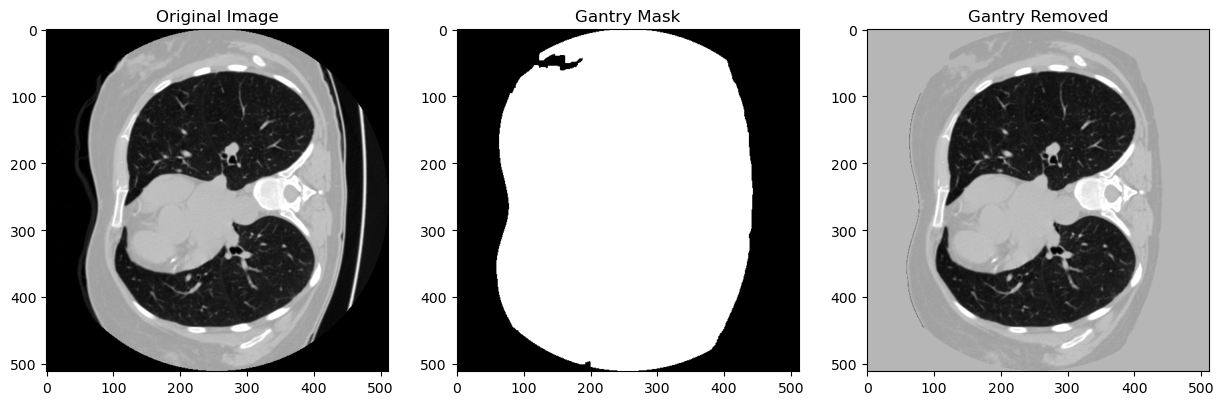

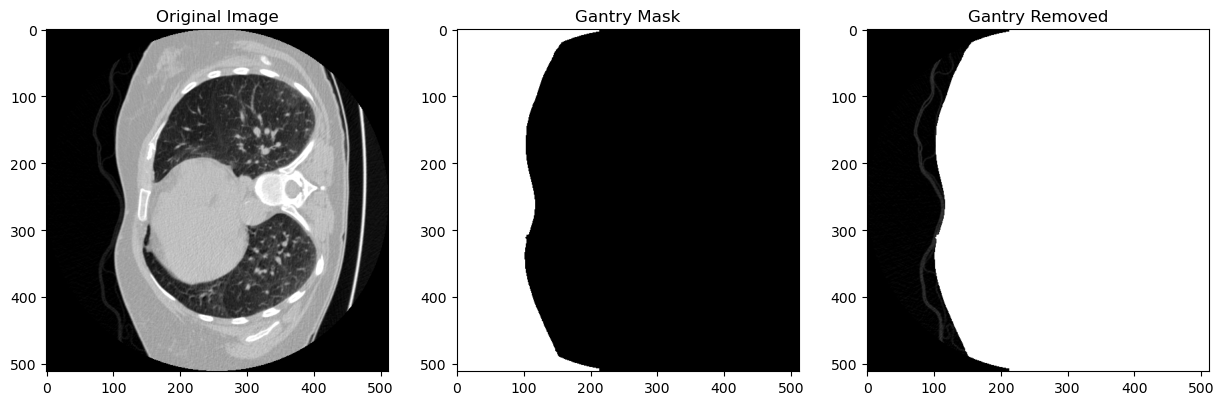

In [9]:
gantry_inhale = remove_gantry(hu_inhale, visualize=True)
gantry_exhale = remove_gantry(hu_exhale, visualize=True)

In [ ]:
def segment_kmeans(image_array, K=3):
    """
    Segment the image using K-means clustering.

    Parameters
    ----------
    image_array : ndarray
        Input image as a NumPy array.
    K : int, optional
        Number of clusters for K-means, by default 3.

    Returns
    -------
    ndarray
        Segmented image as a NumPy array.
    """
    pixels = image_array.flatten().reshape(-1, 1).astype(np.float32)
    _, labels, centers = cv2.kmeans(
        pixels,
        K,
        None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
        10,
        cv2.KMEANS_RANDOM_CENTERS,
    )
    segmented = labels.reshape(image_array.shape)
    return segmented

def fill_chest_cavity(image):
    """
    Fill the chest cavity to obtain the final gantry mask.

    Parameters
    ----------
    image : ndarray
        Input binary image.

    Returns
    -------
    ndarray
        Chest cavity filled binary mask.
    """
    image = image.astype(np.uint8)
    filled_image = np.zeros_like(image)
    for i in range(image.shape[2]):  # Iterate over slices along z-axis
        slice_ = image[:, :, i]
        contours, _ = cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros(slice_.shape, dtype="uint8")
        area = [cv2.contourArea(contour) for contour in contours]
        if len(area) == 0:
            continue
        index_contour = area.index(max(area))
        cv2.drawContours(mask, contours, index_contour, 255, -1)
        kernel = np.ones((7, 7), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        filled_image[:, :, i] = mask
    return filled_image / 255

def remove_gantry(input_array, visualize=False):
    """
    Creates a segmentation mask for the input CT image (as a NumPy array) and removes the gantry.

    Parameters
    ----------
    input_array : ndarray
        Input CT image as a 3D NumPy array (shape: x, y, z).
    visualize : bool, optional
        Whether to visualize intermediate steps and results, by default False.

    Returns
    -------
    tuple
        - gantry_removed_array: 3D NumPy array, the CT image with the gantry removed.
        - gantry_mask: 3D binary mask used for gantry removal.
    """
    # Rescale intensity to [0, 255]
    rescaled_array = cv2.normalize(input_array, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    # Perform K-means segmentation
    segmented_array = segment_kmeans(rescaled_array)

    # Generate the gantry mask
    gantry_mask = segmented_array * (segmented_array == 1)
    gantry_mask_filled = fill_chest_cavity(gantry_mask)

    # Remove the gantry
    gantry_removed_array = np.multiply(input_array, gantry_mask_filled)

    if visualize:
        mid_slice = input_array.shape[2] // 2  # Middle slice along z-axis
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(input_array[:, :, mid_slice], cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(gantry_mask_filled[:, :, mid_slice], cmap="gray")
        ax[1].set_title("Gantry Mask")
        ax[2].imshow(gantry_removed_array[:, :, mid_slice], cmap="gray")
        ax[2].set_title("Gantry Removed")
        plt.show()

    return gantry_removed_array, gantry_mask_filled

In [ ]:
k_means = segment_kmeans(gantry_inhale)